In [1]:
%matplotlib inline
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from sklearn.manifold import TSNE
import seaborn as sns

#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft
import functions.stats as st

plt.ion()   # interactive mode

/home/mtezcan/anaconda3/lib/python3.6/site-packages/torchsample-0.1.2-py3.6.egg/torchsample/datasets.py:16: UserWarning: Cant import nibabel.. Cant load brain images


In [68]:
#model_ft = models.resnet18(pretrained=True).cuda()
model_ft=torch.load('./saved_models/resnet18_real_sgd_multisoft_August29  19:42:44')
#model_ft=torch.load('./Obsolete/saved_models/resnet18_multi_88_real_7_15_17.mdl')
#model_ft.train(False)

print(model_ft)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

In [65]:
dataset='real'
if(dataset=='real'):
    rootdir='//home//mtezcan//Documents//Hoarding//Data_Sets//pruned//good//train//'  
    tr_dirs, tr_cir, tr_house, tr_room = st.subsetCreator(rootdir,multi_dir=False,im_per_room=0,roomdirs=[''])

    rootdir='//home//mtezcan//Documents//Hoarding//Data_Sets//pruned//good//val//'  
    test_dirs, test_cir, test_house, test_room = st.subsetCreator(rootdir,im_per_room=0,multi_dir=False,roomdirs=[''])
elif(dataset=='synthetic'):
    rootdir='//media//mtezcan//New Volume//HoardingImages//_rated//'
    tr_dirs, tr_cir, tr_house, tr_room = st.subsetCreator(rootdir,im_per_room=10)
    rootdir='//media//mtezcan//New Volume//HoardingImages//_val//'
    test_dirs, test_cir, test_house, test_room = st.subsetCreator(rootdir,im_per_room=40)
else:
    raise ValueError('Undefined dataset '+dataset)

print('Created random directories')
print(len(tr_dirs))
print(len(test_dirs))

Created random directories
768
329


In [69]:
tr_smax=st.extractFeats(tr_dirs,model_ft,outsize=9)
test_smax=st.extractFeats(test_dirs,model_ft,outsize=9)
print(tr_smax.shape)
print(test_smax.shape)

(768, 9)
(329, 9)


In [71]:
test_smax=test_smax_1
tr_pred=np.argmax(tr_smax,axis=1)+1
test_pred=np.argmax(test_smax,axis=1)+1

print(tr_pred.shape)
print(test_pred.shape)
tr_err=np.abs(tr_cir-tr_pred)
test_err=np.abs(test_cir-test_pred)
print(np.histogram(test_err))
#print(test_pred[test_cir==2])
print('Training CIR-1 is '+str(np.mean(tr_err<=1)))
print('Test CIR-1 is '+str(np.mean(test_err<=1)))

(768,)
(900,)


ValueError: operands could not be broadcast together with shapes (329,) (900,) 

[ 4.25966311  2.28413105  4.25966311  5.86528015  6.07927227  3.75277114
  3.34321642  2.28413105  4.6747942   3.80091453  5.34845352  5.21347189
  4.25966311  2.85428023  4.4571991   3.80091453  5.86528015  6.07927227
  5.77204084  3.93758011  5.32595491  3.80091453  3.80091453  5.77204084
  2.28413105  5.86528015  3.34321642  6.71327591  2.28413105  4.6747942
  2.85428023  2.85428023  6.71327591  5.21347189  3.80091453  3.93758011
  5.16040802  4.4571991   5.7379117   6.07927227  5.67225409  5.34845352
  4.4571991   5.77204084  6.07927227  5.97109795  2.77540565  5.32595491
  2.85428023  5.21347189  1.25624812  5.87951183  5.67225409  3.34321642
  5.77204084  5.16040802  6.71327591  0.93014795  2.82284021  0.93014795
  5.87951183  5.86528015  3.75277114  3.80091453  5.16040802  4.6747942
  3.80091453  0.93014795  5.16040802  5.21347189  3.80091453  5.34845352
  5.97109795  5.97109795  6.07927227  2.82284021  2.82284021  5.77204084
  5.87951183  5.97109795  5.77204084  1.25624812  3.8

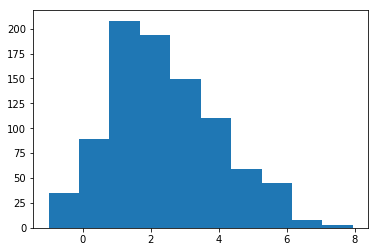

In [54]:
test_scores=np.max(test_smax_1,axis=1)
print(np.mean(test_scores[test_err==0]))
print(np.mean(test_scores[test_err==1]))
print(np.mean(test_scores[test_err==2]))
print(np.mean(test_scores[test_err==3]))
print(np.mean(test_scores[test_err==4]))
plt.hist(test_scores)
print(np.mean(test_scores>=1))
print(np.mean(test_err[test_scores>=1]<=1))

In [ ]:
print('Test CIR-1 is '+str(np.mean(test_err[:900]<=1)))
print('Test CIR-1 is '+str(np.mean(test_err[900:1800]<=1)))
print('Test CIR-1 is '+str(np.mean(test_err[1800:]<=1)))

In [ ]:

plt.hist(test_pred,bins=range(1,11))


In [ ]:
cir0,cir1,cir2=st.class_based_cirs(test_cir,test_pred)
print(cir1)

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(tr_cir,tr_pred)
plt.title('Synthetic Training Set')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')

plt.figure(figsize=(15,10))
sns.boxplot(test_cir,test_pred)
plt.title('Synthetic Validation Set')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')

In [ ]:
sns.jointplot(tr_cir,tr_pred,marginal_kws=dict(bins=range(1,11), rug=True))
plt.title('Joint plot for training')
plt.figure()
sns.jointplot(test_cir,test_pred,marginal_kws=dict(bins=range(1,11), rug=True))
plt.title('Joint plot for validation')

In [ ]:
model_params= list(model_ft.children())
network = nn.Sequential(*list(model_params)[:-1])
print(network)
tr_fvec=st.extractFeats(tr_dirs,network,batchsize=8,outsize=2048)
test_fvec=st.extractFeats(test_dirs,network,batchsize=8,outsize=2048)

print('Constructed Features')

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tr_tsne=model.fit_transform(tr_fvec) 
test_tsne=model.fit_transform(test_fvec)

print('Constructed t-SNE embeddings')

In [ ]:
tsne_resnet=test_tsne.copy()

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(tr_tsne[:,0], tr_tsne[:,1], c=tr_cir, alpha=0.5)#,cmap='jet')
plt.colorbar()
plt.title('Training')
plt.subplot(122)
plt.scatter(test_tsne[:,0], test_tsne[:,1], c=test_cir, alpha=0.5)#,cmap='jet')
plt.colorbar()
plt.title('Validation')

In [ ]:
st.plotAll(tr_tsne,tr_cir,tr_house,tr_room,data_title='Training')
st.plotAll(test_tsne,test_cir,test_house,test_room,data_title='Test')

In [ ]:
st.plotAll(tr_tsne,tr_cir,tr_house,tr_room,data_title='Training')
st.plotAll(test_tsne,test_cir,test_house,test_room,data_title='Test')